In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Latin Modern Roman"
})
%config InlineBackend.figure_format='retina'

## Q1: Simple numerical integral

Numerical integration methods work differently depending on whether you have the analytic function available (in which case you can evaluate it freely at any point you please) or if it is sampled for you.

Consider the function $f(x) = e^{-x^2}$.  We want to integrate this from $[-5, 5]$.  The
analytic integral is not easily obtained.  Use `integrate.quad` to do the integration.

In [17]:
from scipy.integrate import quad, simpson, romb
from scipy.stats import uniform

In [5]:
min, max = -5, 5
f = lambda x : np.exp(-x**2)

integral_quad = quad(f, min, max, epsabs=1e-10, epsrel=1e-10)
print(f'Integrated value = {integral_quad[0]:.5f}, error = {integral_quad[1]:.2e}')
print(f'F-sqrt(pi) = {np.abs(integral_quad[0] - np.sqrt(np.pi)):.2e}')

Integrated value = 1.77245, error = 4.66e-14
F-sqrt(pi) = 2.72e-12


Consider now that you have data that represents a function sampled a `N` points, but you don't know the analytic form of the function.  Here, we create the sampling from a uniform distribution

Compute the integral of this sampled function using Simpson's method (`integrate.simps`).  Now, vary the number of sample points (try 64, 128, ...) and see how the answer changes.  Simpson's method is 4-th order accurate, which means that the error should decrease by $2^4$ when we double the number of sample points

In [21]:
N = np.linspace(10, 10000, 100, dtype=int)
integral_simps = []
for n in N:
    x = np.linspace(min, max, n)
    y = f(x)
    integral_simps += [simpson(y, x)]

In [29]:
N2 = 2**np.arange(3, 13)+1
integral_romb = []
for n in N2:
    x = np.linspace(min, max, n)
    y = f(x)
    
    integral_romb += [romb(y, dx=x[1]-x[0])]

In [7]:
integral_MC = []
for n in N:
    x = uniform.rvs(loc=min, scale=max-min, size=n)
    integral_MC += [(max-min)*np.mean(f(x))]

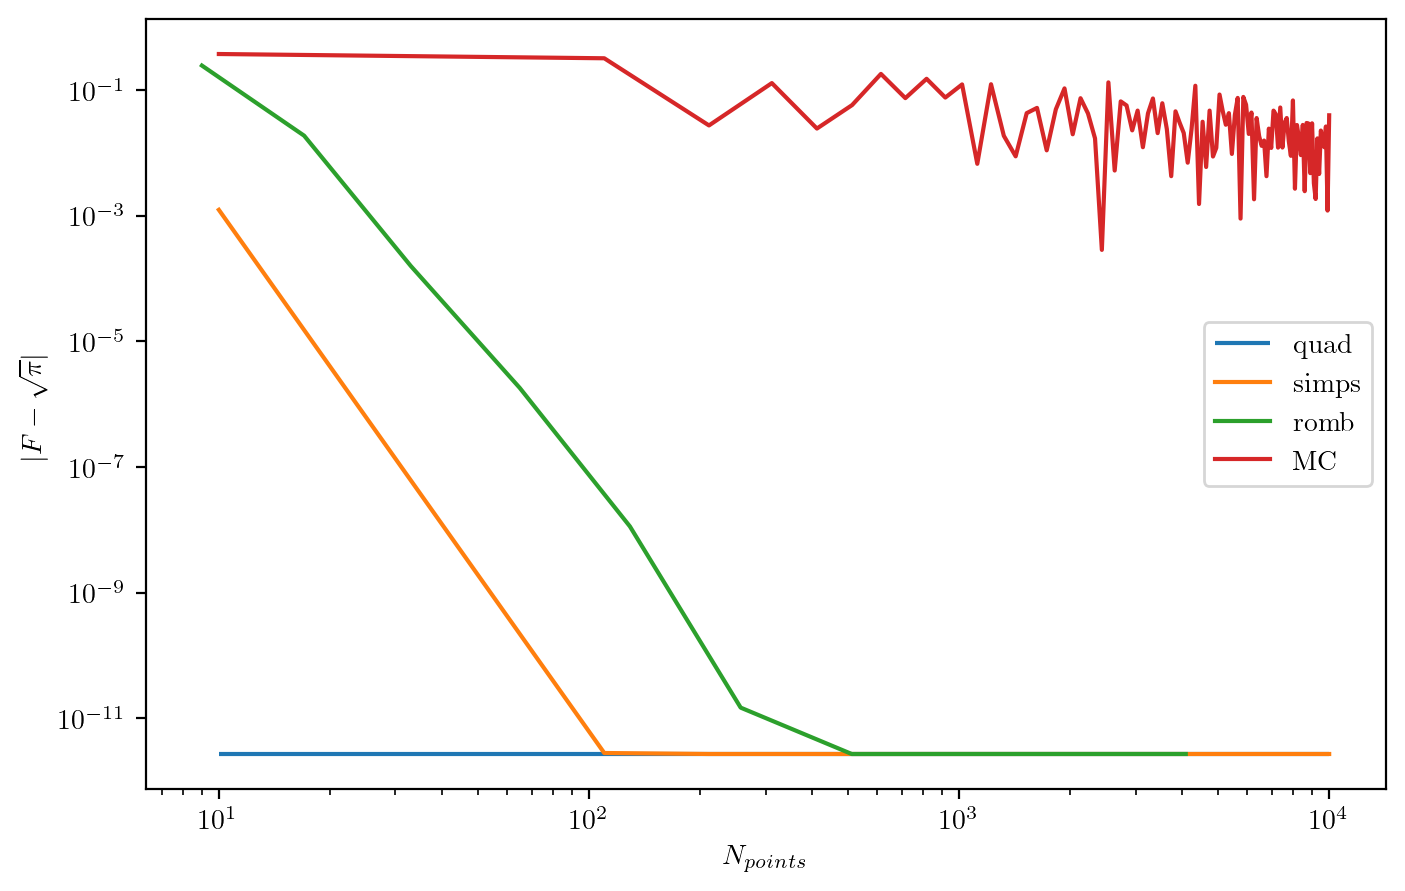

In [34]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

ax.hlines(np.abs(integral_quad[0] - np.sqrt(np.pi)), N[0], N[-1], color='C0', label='quad')
ax.plot(N, np.abs(integral_simps - np.sqrt(np.pi)), color='C1', label='simps')
ax.plot(N2, np.abs(integral_romb - np.sqrt(np.pi)), color='C2', label='romb')
ax.plot(N, np.abs(integral_MC - np.sqrt(np.pi)), color='C3', label='MC')
ax.set_xlabel(r'$N_{points}$')
ax.set_ylabel(r'$|F - \sqrt{\pi}|$')
ax.semilogx()
ax.semilogy()
plt.legend(loc=7)

## Q2: Interpolation error

There are a large number of different interpolation schemes available through scipy.  Let's test them out.

Create a python function, $f(x)$, that is your true function (make it complicated!).  Now create $N$ samples of it (either regularly spaced or irregularly spaced).

Try some of the different interpolation routines.  `interpolate.interp1d` takes a `kind` argument that let's you choose the order of the interpolation.  Measure the error in the method, by comparing the interpolated result with the actual function value.  

Then do the same cubic splines (look at `CubicSpline`)

Plot the resulting interpolant.

In [179]:
from scipy.interpolate import interp1d, CubicSpline
from sklearn.gaussian_process import GaussianProcessRegressor

In [161]:
def f(x):
    return 10*np.abs(np.sin(x/3))*np.exp(-(x/5)**2) + (x/8)**2

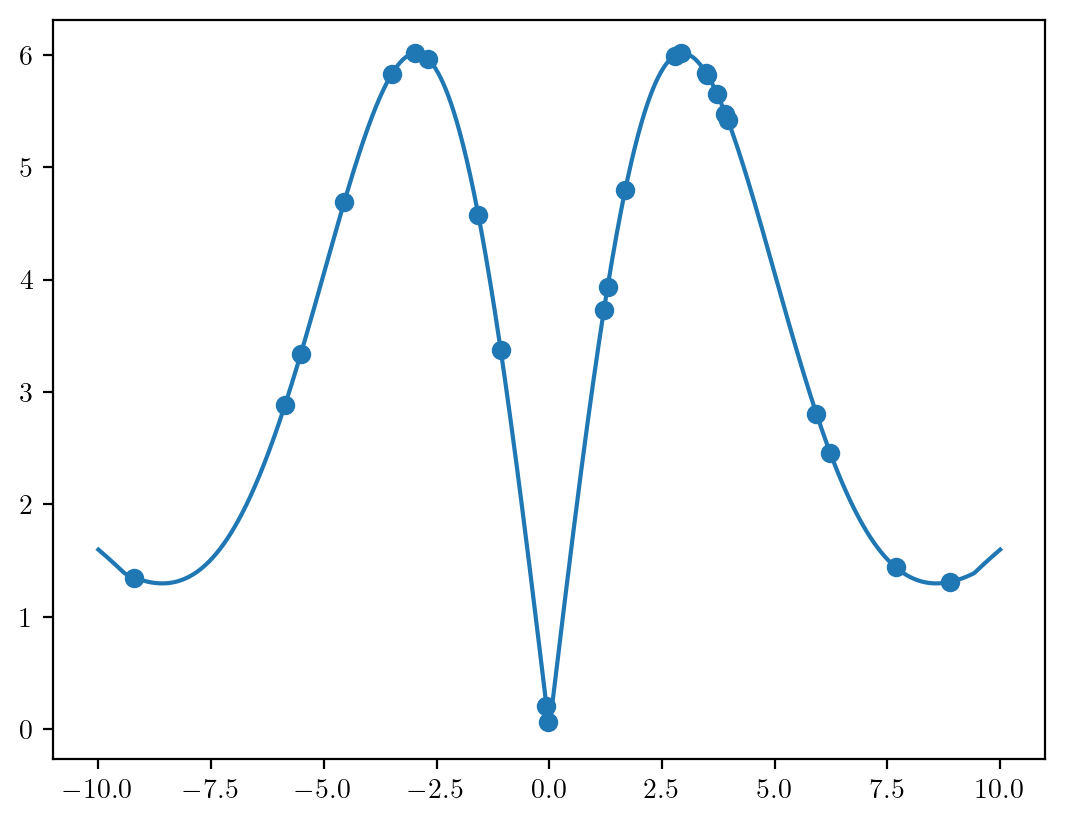

In [163]:
x = np.linspace(-10,10,1000)
X = np.array(sorted(np.random.uniform(low=-10, high=10, size=25)))
plt.plot(x, f(x))
plt.scatter(X, f(X))

In [186]:
interp1 = interp1d(X, f(X), kind='nearest', fill_value='extrapolate')
interp2 = interp1d(X, f(X), kind='linear', fill_value='extrapolate')
interp3 = interp1d(X, f(X), kind='quadratic', fill_value='extrapolate')
interp4 = CubicSpline(X, f(X))
interp5 = GaussianProcessRegressor().fit(X[:,np.newaxis], f(X[:,np.newaxis]))

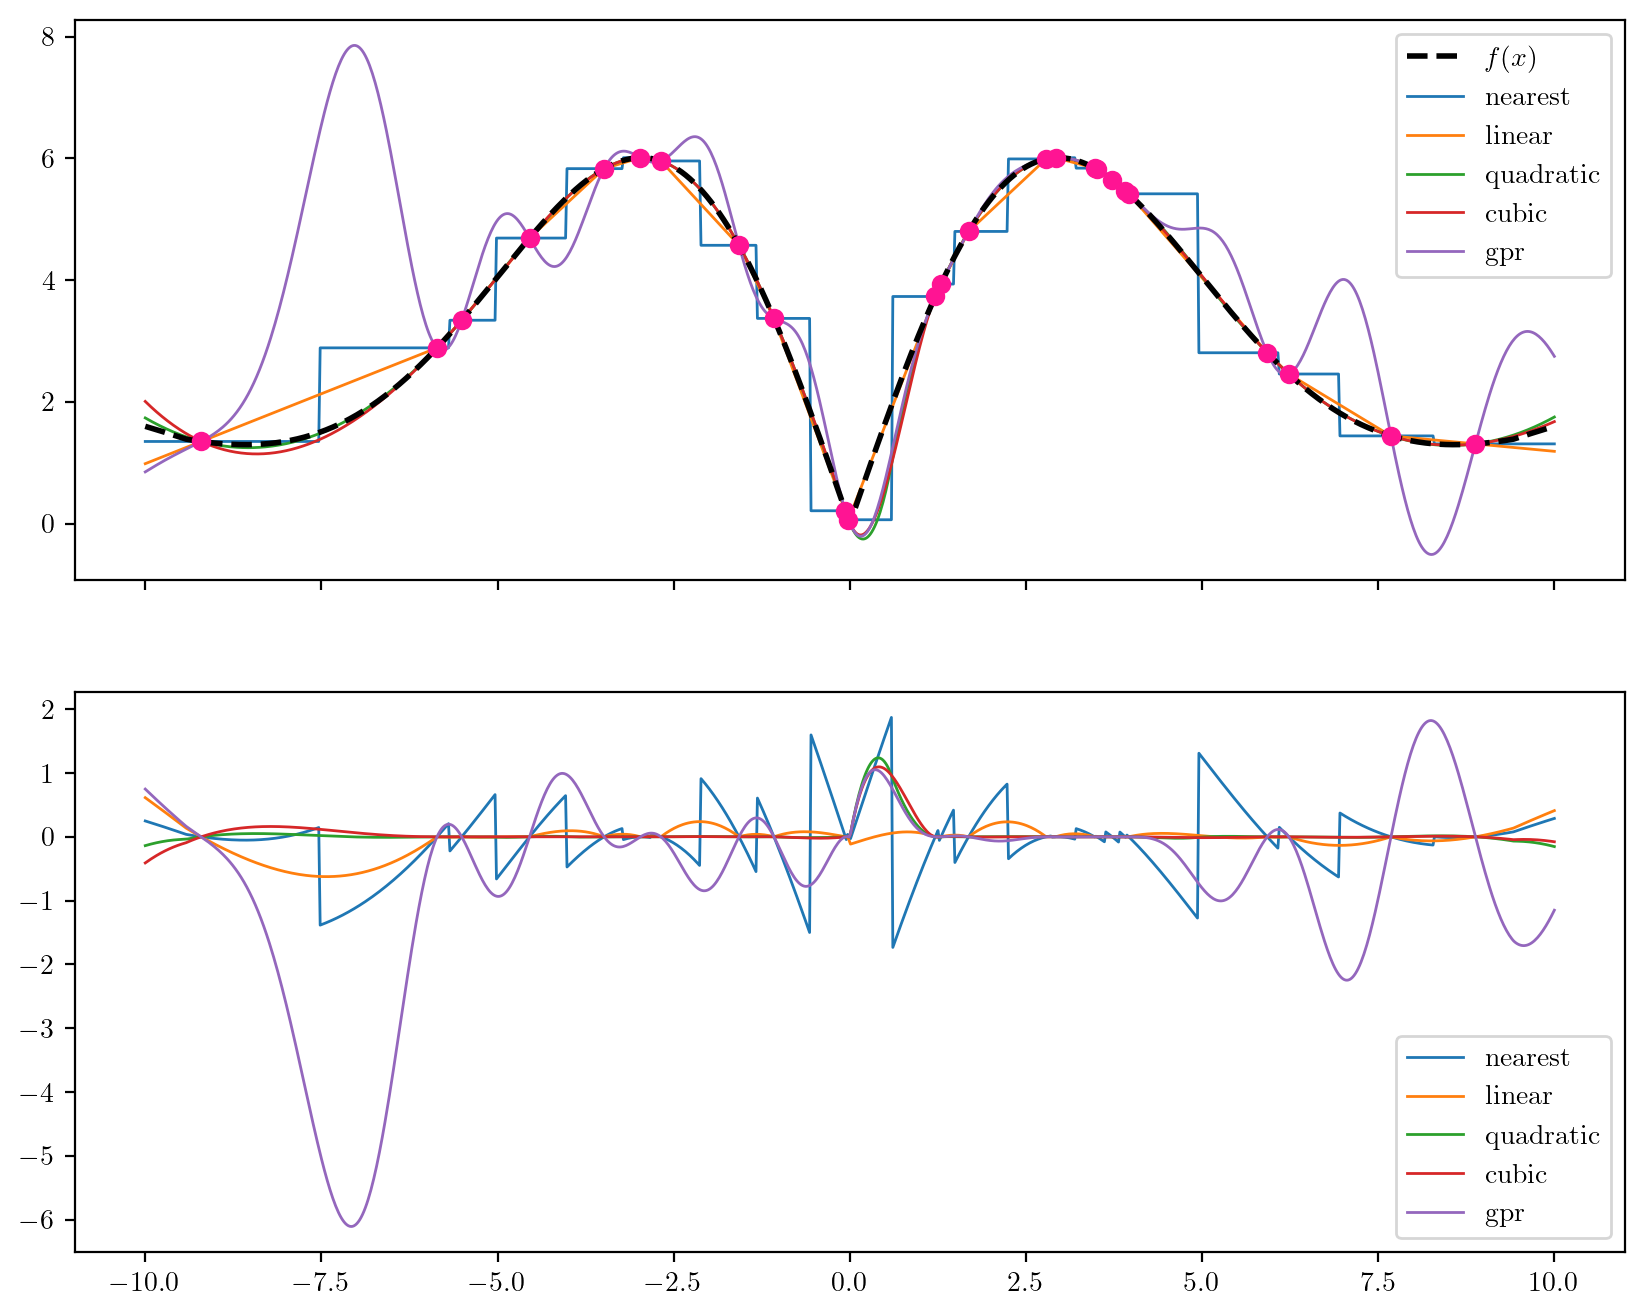

In [187]:
fig = plt.figure(figsize=(10,8))
axs = fig.subplots(2,1, sharex=True)

axs[0].plot(x, f(x), color='k', linewidth=2, linestyle='--', zorder=9, label=r'$f(x)$')
axs[0].plot(x, interp1(x), linewidth=1, label='nearest')
axs[0].plot(x, interp2(x), linewidth=1, label='linear')
axs[0].plot(x, interp3(x), linewidth=1, label='quadratic')
axs[0].plot(x, interp4(x), linewidth=1, label='cubic')
axs[0].plot(x, interp5.predict(x[:,np.newaxis]), linewidth=1, label='gpr')
axs[0].legend()
axs[0].scatter(X, f(X), c='deeppink', zorder=10)


axs[1].plot(x, f(x) - interp1(x), linewidth=1, label='nearest')
axs[1].plot(x, f(x) - interp2(x), linewidth=1, label='linear')
axs[1].plot(x, f(x) - interp3(x), linewidth=1, label='quadratic')
axs[1].plot(x, f(x) - interp4(x), linewidth=1, label='cubic')
axs[1].plot(x, f(x) - interp5.predict(x[:,np.newaxis]), linewidth=1, label='gpr')
axs[1].legend()

## Q3: Basins of attraction

Consider the function

$$q(x) = x^3 - 2x^2 - 11x + 12$$

This has 3 roots has you should find them all. This equation is known to cause problems for some root-finding methods  becauses it exhibits [basis of attraction](https://en.wikipedia.org/wiki/Newton%27s_method#Basins_of_attraction) -- very closely spaced initial guesses leave to very different roots.

Use the scipy `optimize.brentq` method to find the roots.  You might need to play around with the intervals to find all 3 roots (try plotting the function to help)

In [189]:
from scipy.optimize import brentq

(-43.6, 35.6)

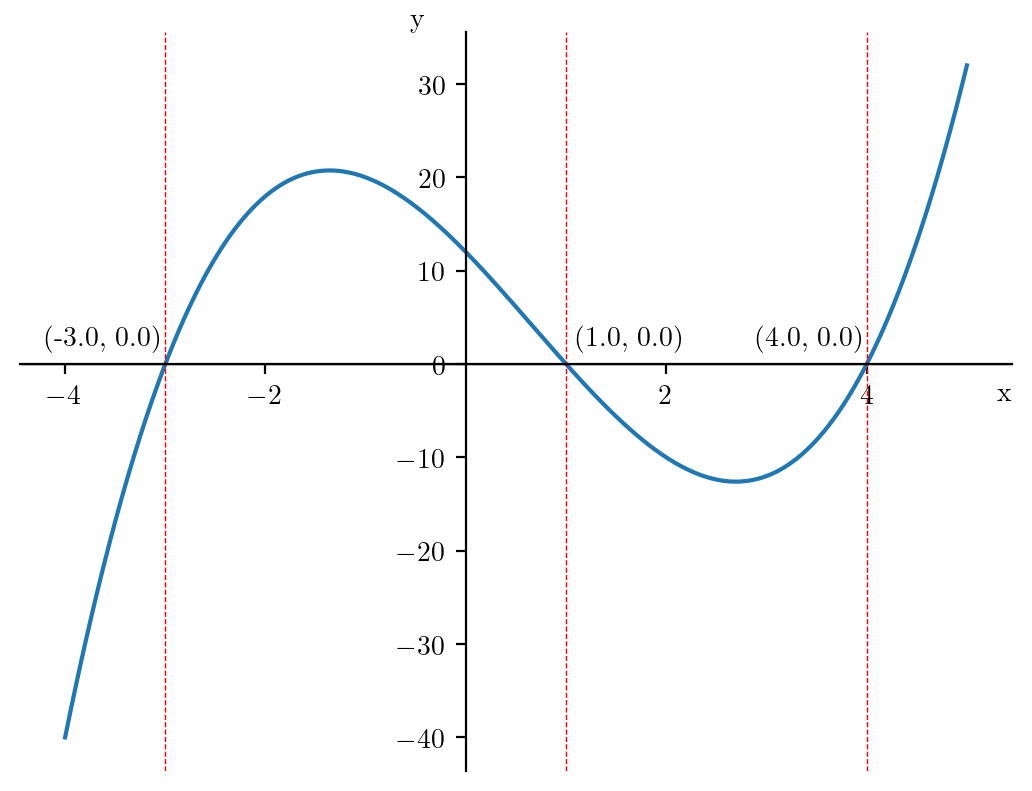

In [234]:
f = lambda x : x**3-2*x**2-11*x+12
x = np.linspace(-4, 5, 1000)
y = f(x)

roots = [brentq(f, -4, -2), brentq(f, 0, 2), brentq(f, 3, 5)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.plot(x, y)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(0, xlim[0], xlim[1], color='k', linewidth=0.5)
ax.vlines(roots[0], ylim[0], ylim[1], color='r', linewidth=0.5, linestyle='--')
ax.annotate(f'({roots[0]:.1f}, {f(roots[0]):.1f})', (roots[0]-1.2, f(roots[0])+2))
ax.vlines(roots[1], ylim[0], ylim[1], color='r', linewidth=0.5, linestyle='--')
ax.annotate(f'({roots[1]:.1f}, {f(roots[1]):.1f})', (roots[1]+0.1, f(roots[1])+2))
ax.vlines(roots[2], ylim[0], ylim[1], color='r', linewidth=0.5, linestyle='--')
ax.annotate(f'({roots[2]:.1f}, {f(roots[2]):.1f})', (roots[2]-1.1, f(roots[2])+2))
ax.set_xlabel('x', loc='right', labelpad=-10)
ax.set_ylabel('y', loc='top', rotation=0, labelpad=-10)
ax.set_xticks([-4,-2,2,4])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

## Q5: Planetary orbits

We want to consider planetary orbits.  To do this, we need to solve Newton's second law together with Newton's law of gravity.  If we restrict ourselves to the x-y plane, then there are 4 quantities we need to solve for: $x$, $y$, $v_x$, and $v_y$.  These evolve according to:

\begin{align*}
\frac{dx}{dt} &= v_x \\
\frac{dy}{dt} &= v_y \\
\frac{dv_x}{dt} &= a_x = -\frac{GM_\star x}{r^3} \\
\frac{dv_y}{dt} &= a_y = -\frac{GM_\star y}{r^3}
\end{align*}

To integrate these forward in time, we need an initial condition for each quantity.  We'll setup our system such that the Sun is at the origin (that will be one focus), and the planet begins at perihelion and orbits counterclockwise. 

![orbit_setup.png](attachment:orbit_setup.png)

The distance of perihelion from the focus is:

$$r_p = a (1 - e)$$

where $a$ is the semi-major axis and $e$ is the eccentricity.  The perihelion velocity is all in the $y$ direction and is:

$$v_y = v_p = \sqrt{\frac{GM_\star}{a} \frac{1+e}{1-e}}$$

We'll work in units of AU, years, and solar masses, in which case, $GM_\star = 4\pi^2$ (for the Sun).  

Your initial conditions should be:

  * $x(t=0) = r_p$
  * $y(t=0) = 0$
  * $v_x(t=0) = 0$
  * $v_y(t=0) = v_p$

In [236]:
from scipy.integrate import odeint

def eqs(t, X):
    r = np.sqrt(X[0]**2+X[1]**2)
    
    dxdt = X[2]
    dydt = X[3]
    dvxdt = -4*np.pi**2*X[0]/r**3
    dvydt = -4*np.pi**2*X[1]/r**3

    return [dxdt, dydt, dvxdt, dvydt]

def X0(a, e):
    return [a*(1-e), 0, 0, np.sqrt(4*np.pi**2/a*(1+e)/(1-e))]

In [241]:
tf = 1
t = np.linspace(0, tf, 1000)
a = 1
e = 0.2

orbit = odeint(eqs, X0(a, e), t, tfirst=True)

(-2.0, 2.0)

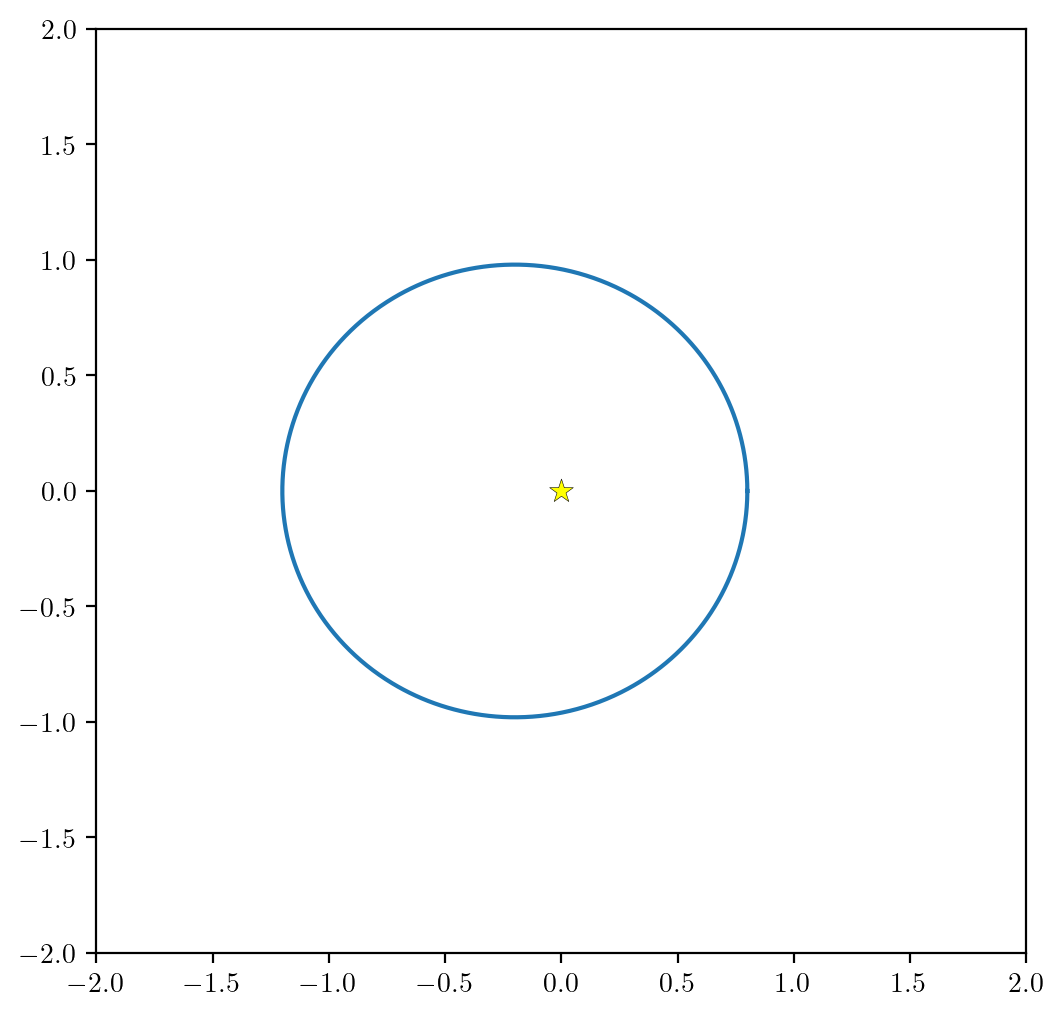

In [242]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.plot(orbit[:,0], orbit[:,1])
ax.scatter(0,0, marker='*', color='yellow', edgecolor='k', linewidths=0.2, s=80)
ax.set_xlim(-2*a, 2*a)
ax.set_ylim(-2*a, 2*a)

## Q6: Damped driven pendulum and chaos

There are a large class of ODE integration methods available through the `scipy.integrate.ode()` function.  Not all of them provide _dense output_ -- most will just give you the value at the end of the integration.  

The explicit Runge-Kutta integrator will give you access to the solution at intermediate points and provides methods to interpolate to any value.  You enable this via `dense_output=True`.

The damped driven pendulum obeys the following equations:

$$\dot{\theta} = \omega$$

$$\dot{\omega} = -q \omega - \sin \theta + b \cos \omega_d t$$

here, $\theta$ is the angle of the pendulum from vertical and $\omega$ is the angular velocity.  $q$ is a damping coefficient, $b$ is a forcing amplitude, and $\omega_d$ is a driving frequency.

Choose $q = 0.5$ and $\omega_d = 2/3$.

Integrate the system for different values of $b$ (start with $b = 0.9$ and increase by $0.05$, and plot the results ($\theta$ vs. $t$).  Here's a RHS function to get you started:

In [246]:
from scipy.integrate import solve_ivp

In [247]:
def rhs(t, Y, q, omega_d, b):
        """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
        f = np.zeros_like(Y)
        
        f[0] = Y[1]
        f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

        return f

Note that the pendulum can flip over, giving values of $\theta$ outside of $[-\pi, \pi]$.  The following function can be used to restrict it back to $[-\pi, \pi]$ for plotting.

In [244]:
def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

Write a function that takes an initial angle, $\theta_0$, and integrates the system and returns the solution.

Note, the righthand side function, `rhs`, takes additional arguments that you need to pass through the integrator.  The preferred method to do this with the `solve_ivp()` interface appears to be to use `functools.partial()`, as:
```
from functools import partial

r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b), ...)
```

Some values of $b$ will show very non-periodic behavior.  To see chaos, integrate two different pendula that are the same except for $\theta_0$, with only a small difference between then (like 60 degrees and 60.0001 degrees.  You'll see the solutions track for a while, but then diverge.

In case of a damped forced pendulum the evolution of the angle $\theta$ follows this relation: 
\begin{equation*}
    \theta(t)= \frac{b}{G} \sin(\omega_d t -\alpha)
\end{equation*}

In [294]:
t0 = 0
tf = 100
theta0 = 0
omega0 = 0
q = 0.8
omega_d = 2/3
b = 0.9

evo = solve_ivp(rhs, (t0,tf), y0=(theta0, omega0), args=(q, omega_d, b), dense_output=True)

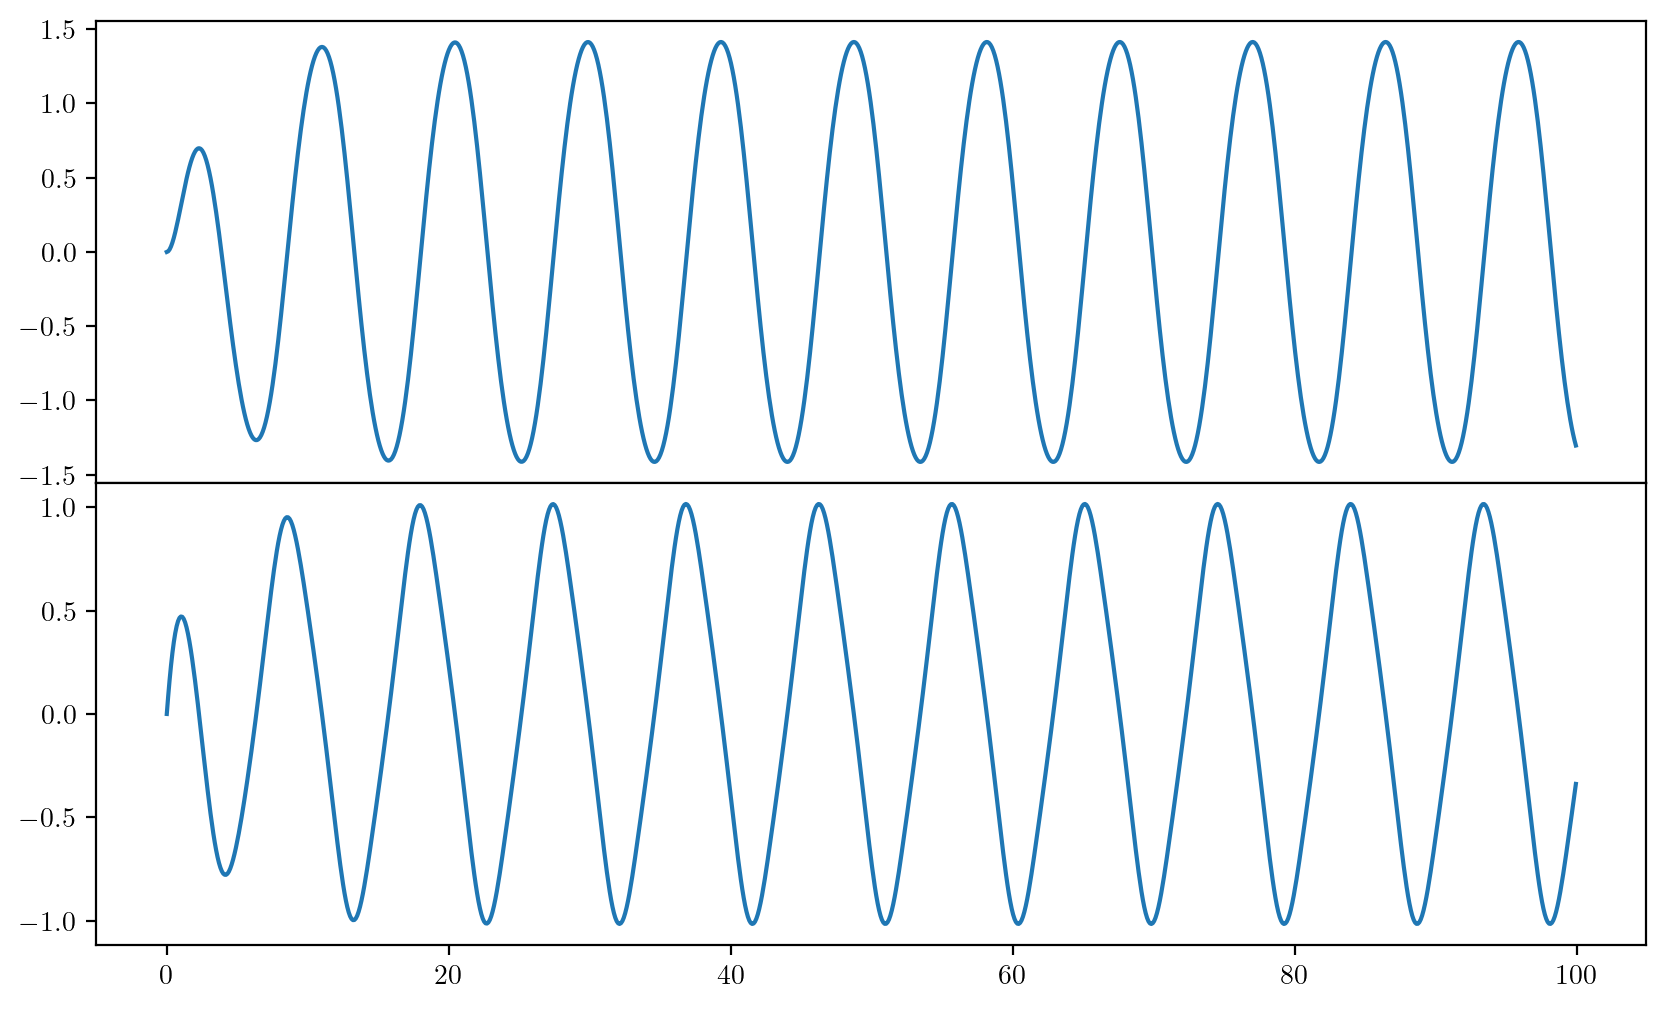

In [295]:
fig = plt.figure(figsize=(10,6))
fig.subplots_adjust(hspace=0)
axs = fig.subplots(2,1, sharex=True)

t = np.arange(0, 100, 0.1)

axs[0].plot(t, restrict_theta(evo.sol(t)[0]))
axs[1].plot(t, evo.sol(t)[1])

## Q6: Condition number

For a linear system, ${\bf A x} = {\bf b}$, we can only solve for $x$ if the determinant of the matrix ${\bf A}$ is non-zero.  If the determinant is zero, then we call the matrix _singular_.  The _condition number_ of a matrix is a measure of how close we are to being singular.  The formal definition is:

\begin{equation}
\mathrm{cond}({\bf A}) = \| {\bf A}\| \| {\bf A}^{-1} \|
\end{equation}

But we can think of it as a measure of how much ${\bf x}$ would change due to a small change in ${\bf b}$.  A large condition number means that our solution for ${\bf x}$ could be inaccurate.

A _Hilbert matrix_ has $H_{ij} = (i + j + 1)^{-1}$, and is known to have a large condition number.  Here's a routine to generate a Hilbert matrix (with a `for` loop, I'm a terrible programmer!) 

In [2]:
from scipy.linalg import solve, lstsq

In [3]:
def hilbert(n):
    """ return a Hilbert matrix, H_ij = (i + j - 1)^{-1} """
    
    #sum(mgrid(1:n+1,1:n+1), axis=0)-1 == sum(mgrid(1:n+1,0:n), axis=0)
    return 1/np.sum(np.mgrid[1:n+1,0:n], axis=0) 

Let's solve ${\bf Hx} ={\bf b}$.  Create a linear system by picking an ${\bf x}$ and generating a ${\bf b}$ by multiplying by the matrix ${\bf H}$.  Then use the `scipy.linalg.solve()` function to recover ${\bf x}$.  Compute the error in ${\bf x}$ as a function of the size of the matrix.

You won't need a large matrix, $n \sim 13$ or so, will start showing big errors.

You can compute the condition number with `numpy.linalg.cond()`

There are methods that can do a better job with nearly-singular matricies.  Take a look at `scipy.linalg.lstsq()` for example.

In [4]:
N = np.arange(2, 30, 2)
errors = []
cond = []
for n in N:
    x = np.random.uniform(low=-1, high=1, size=n)
    H = hilbert(n)
    b = H @ x
    
    errors += [[np.sqrt(np.sum((x-solve(H,b))**2)), np.sqrt(np.sum((x-lstsq(H,b)[0])**2))]]
    cond += [np.linalg.cond(H)]

errors = np.array(errors)
cond = np.array(cond)

/var/folders/zk/yz_63bvd4ss1lbqszrdsg4qm0000gn/T/ipykernel_1830/1471985911.py:9: LinAlgWarning: Ill-conditioned matrix (rcond=2.48656e-17): result may not be accurate.
  errors += [[np.sqrt(np.sum((x-solve(H,b))**2)), np.sqrt(np.sum((x-lstsq(H,b)[0])**2))]]
/var/folders/zk/yz_63bvd4ss1lbqszrdsg4qm0000gn/T/ipykernel_1830/1471985911.py:9: LinAlgWarning: Ill-conditioned matrix (rcond=1.47287e-18): result may not be accurate.
  errors += [[np.sqrt(np.sum((x-solve(H,b))**2)), np.sqrt(np.sum((x-lstsq(H,b)[0])**2))]]
/var/folders/zk/yz_63bvd4ss1lbqszrdsg4qm0000gn/T/ipykernel_1830/1471985911.py:9: LinAlgWarning: Ill-conditioned matrix (rcond=4.61901e-19): result may not be accurate.
  errors += [[np.sqrt(np.sum((x-solve(H,b))**2)), np.sqrt(np.sum((x-lstsq(H,b)[0])**2))]]
/var/folders/zk/yz_63bvd4ss1lbqszrdsg4qm0000gn/T/ipykernel_1830/1471985911.py:9: LinAlgWarning: Ill-conditioned matrix (rcond=1.61032e-19): result may not be accurate.
  errors += [[np.sqrt(np.sum((x-solve(H,b))**2)), np.sqrt(

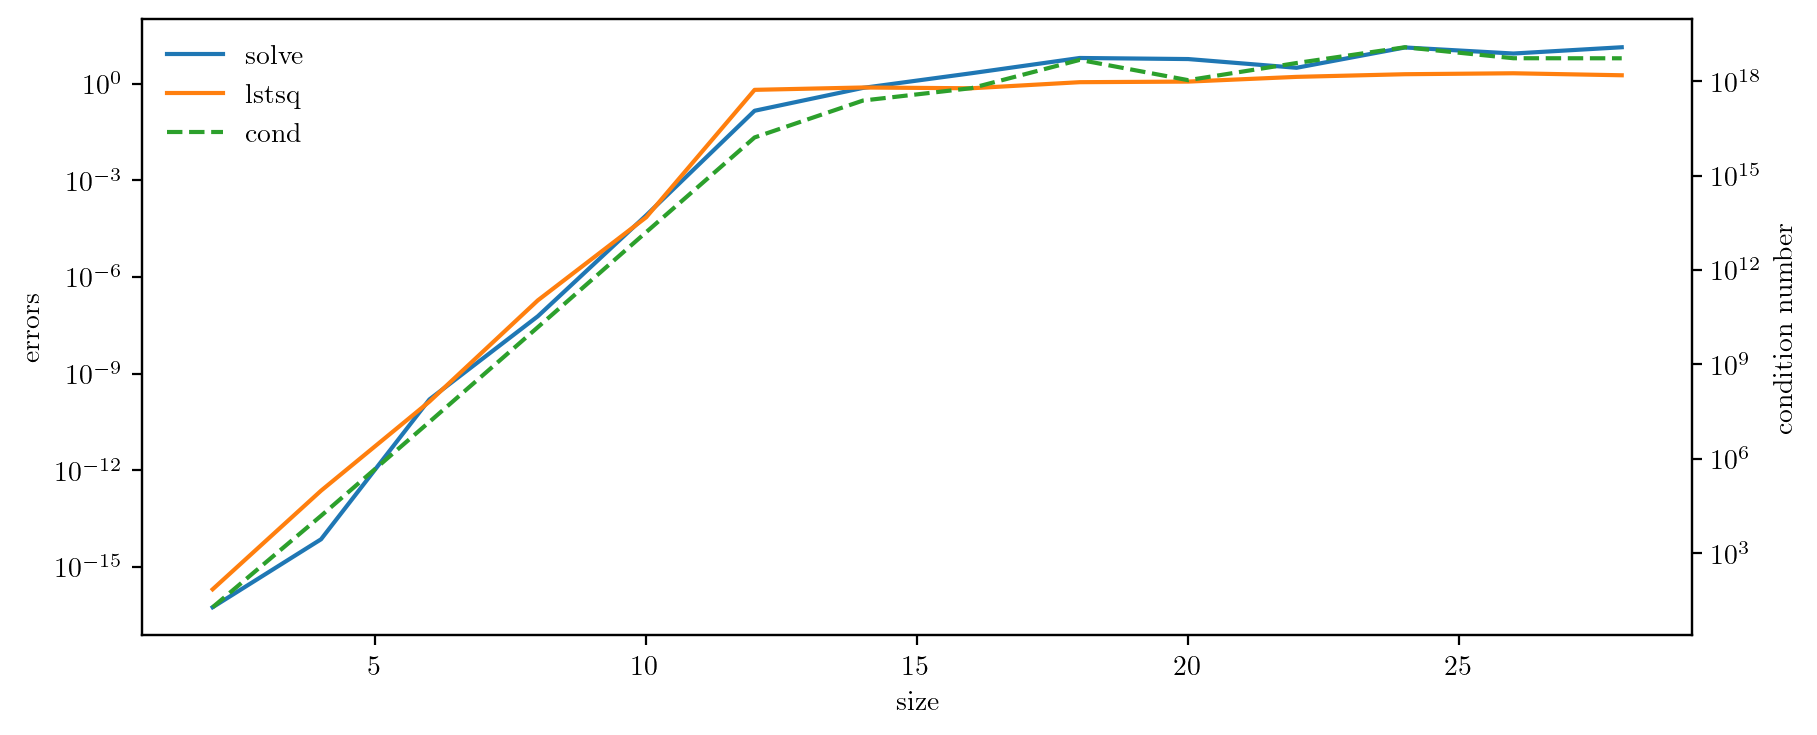

In [28]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)

ax.plot(N, errors[:,0], label='solve')
ax.plot(N, errors[:,1], label='lstsq')
ax.semilogy()
ax.set_xlabel('size')
ax.set_ylabel('errors')
ax.legend(loc='upper left', frameon=False)

sax = ax.twinx()
sax.plot(N, cond, color='C2', linestyle='--', label='cond')
sax.set_ylabel('condition number')
sax.semilogy()
sax.legend(loc=(0.009,0.775), frameon=False)

## Q7: Noisy signal

A convolution is defined as:  

  \begin{equation}                                                                           
    (f \star g)(t) \equiv \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau                   
  \end{equation}                                                                             

  It is easy to compute this with FFTs, via the _convolution theorem_,                                                                        
  \begin{equation}                                         
    \mathcal{F}\{f \star g\} = \mathcal{F}\{f\} \, \mathcal{F}\{g\}                                          
  \end{equation}                                         
  That is: the Fourier transform of the convolution of $f$ and $g$ is simply
  the product of the individual transforms of $f$ and $g$.  This allows us
  to compute the convolution via multiplication in Fourier space and then take
  the inverse transform, $\mathcal{F}^{-1}\{\}$, to recover the convolution in real space:
  
  \begin{equation}
  f \star g = \mathcal{F}^{-1}\{ \mathcal{F}\{f\} \, \mathcal{F}\{g\}\}
  \end{equation}
  
A common use of a convolution is to smooth noisy data, for example by convolving noisy data with a Gaussian.  We'll do that here.

Here's some noisy data we'll work with

In [33]:
from scipy.signal import convolve
from scipy.signal.windows import gaussian

In [30]:
def fdata(x, L):
    A = L/10.0
    return 2*np.sin(2*np.pi*x/L) + x*(L-x)**2/L**3 * np.cos(x) + \
           5*x*(L-x)/L**2 + A/2 + 0.1*A*np.sin(13*np.pi*x/L)

N = 2048
L = 50.0
x = np.linspace(0, L, N, endpoint=False)
orig = fdata(x, L)
noisy = orig + 0.5*np.random.randn(N)

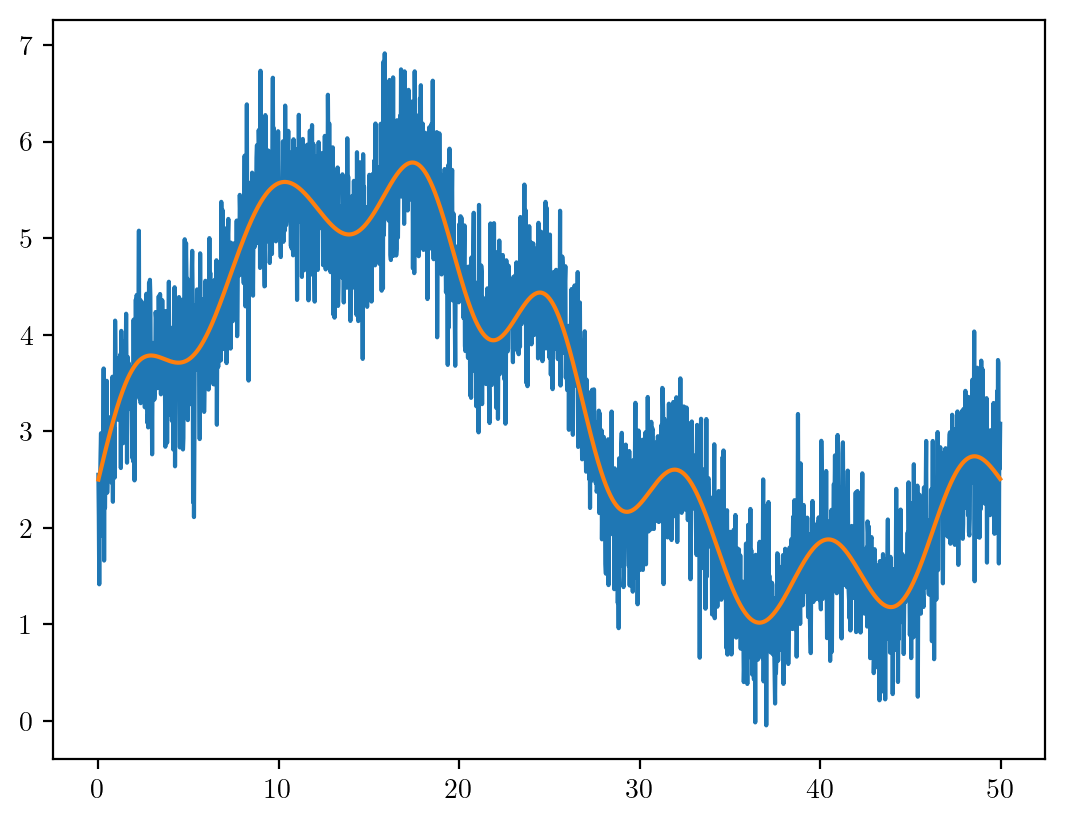

In [31]:
plt.plot(x, noisy)
plt.plot(x, orig)

SciPy provides a convolution function `scipy.signal.convolve()` that can do the convolution for us directly.  To smooth the data, we want to use a Gaussian, which can be produced by `scipy.signal.gaussian()`.

Convolve the noisy data with a Gaussian and plot the result together with the original data `orig`.  You'll need to play with the width of the Gaussian to get a nice smoothing.  You also will need to normalize the Gaussian so that it sums to 1, otherwise, your convolved data will be shifted verfically from the original function.

In [66]:
from scipy.optimize import minimize
func = lambda std : np.sum((orig - convolve(noisy, 1/np.sqrt(2*np.pi*std**2)*gaussian(M=N, std=std, sym=True), \
                                            method='fft', mode='same'))**2)

minimize(func, x0=20)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 25.3307324377098
        x: [ 8.929e+00]
      nit: 6
      jac: [-4.768e-07]
 hess_inv: [[ 2.621e+00]]
     nfev: 20
     njev: 10

In [69]:
std = 8.929
gauss = 1/np.sqrt(2*np.pi*std**2)*gaussian(M=N, std=std, sym=True)
conv = convolve(noisy, gauss, method='fft', mode='same')

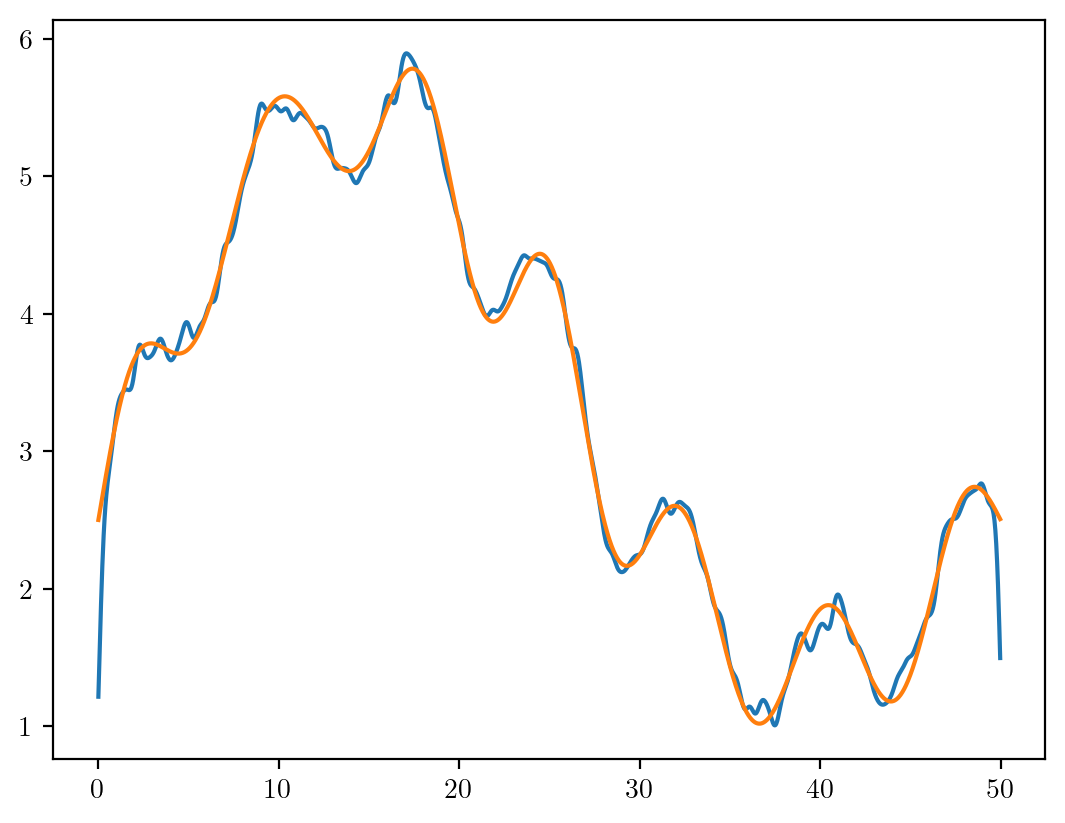

In [70]:
plt.plot(x, conv)
plt.plot(x, orig)

## Q8: FFT of the chaotic pendulum

In Q6 we looked at ODEs and the chaotic pendulum, and were interested in writing a method to integrate the pendulum in time.

Here we want to examine its behavior in frequency space.  The code below will integrate the chaotic pendulum, while requesting that the solution be stored at points spaced with a fixed dt, which makes it suitable for taking the FFT.

In [74]:
from functools import partial
from scipy.integrate import solve_ivp

def rhs(t, Y, q, omega_d, b):
    """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
    f = np.zeros_like(Y)
        
    f[0] = Y[1]
    f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

    return f

def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

def int_pendulum(theta0, q, omega_d, b, tend, dt):
    """ integrate the pendulum and return solution with dt"""

    # points in time where we'll request the solution
    tpoints = np.arange(0.0, tend, dt)
    
    r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b),
                  [0.0, tend], [theta0, 0.0],
                  method='RK45', t_eval=tpoints)

    return r.t, r.y

The call below will give an undamped pendulum.  For a small amplitude, since we have $L = g$ in our pendulum, the period is simply $T = 2\pi$, and the frequency is $\nu_k = 1/(2\pi)$.  We plot things in terms of angular frequency, $\omega_k = 2\pi \nu_k$, so all the power will be at $\omega_k = 1$.

In [75]:
t, y = int_pendulum(np.radians(10), 0.0, 0.6666, 0.0, 200.0, 0.1)

Your task is to complete the power spectrum routine below to calculate the FFT of theta and plot it.  Experiment with the damping and driving parameters to see the complexity of the pendulum in frequency space when it becomes chaotic.  For reference, here's a plot of the solution theta

Text(0, 0.5, '$\\theta$')

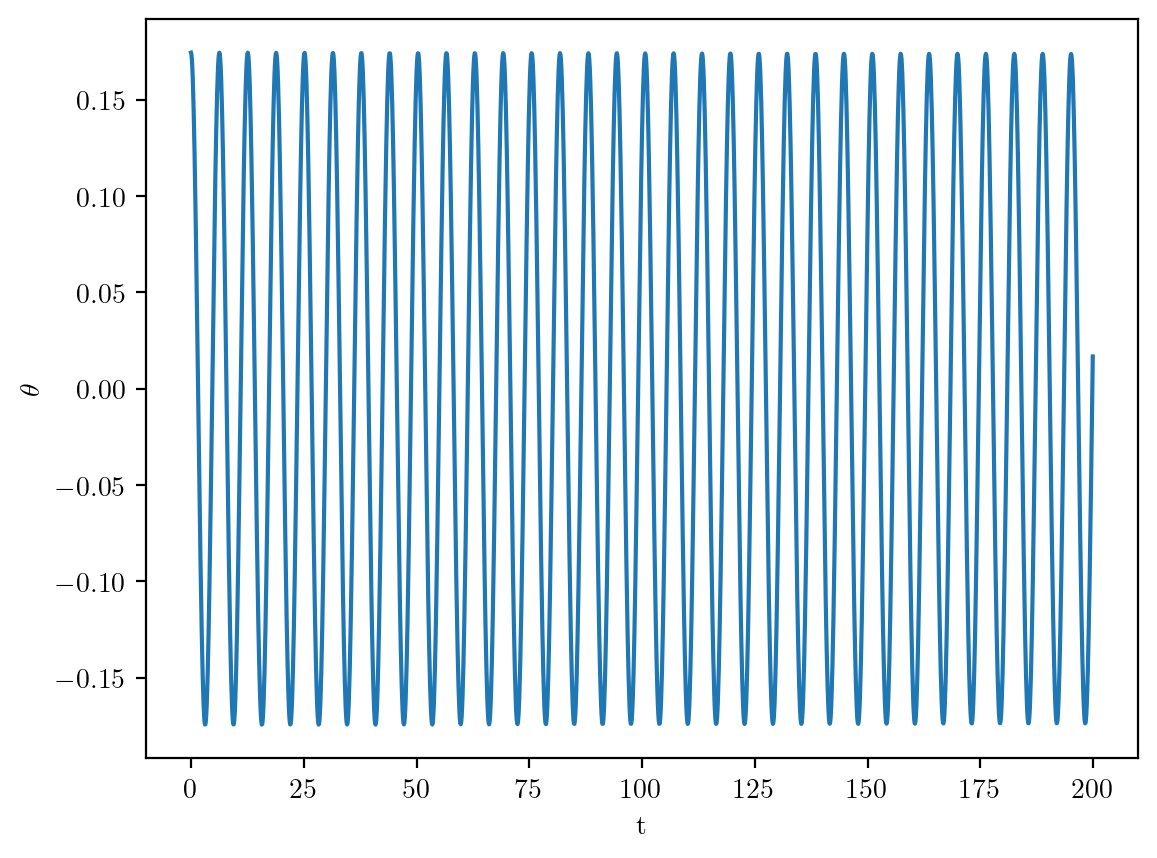

In [76]:
plt.plot(t, restrict_theta(y[0,:]))
plt.xlabel("t")
plt.ylabel(r"$\theta$")

In [73]:
def power_spectrum(t, theta0):
    """ return the power spectrum of theta.  For the frequency
        component, return it in terms of omega """

    theta = restrict_theta(theta0)
    
    # fill in the rest -- take the FFT of theta and return omega_k and 
    # the transform of theta
